## Reading the data

In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


df = pd.read_csv("../../corpus_sprint3_balanced_cleaned_all.csv", encoding="utf-8")
df = df.dropna()
print(df)
print(df.shape)

model = Doc2Vec.load("../../model_doc2vec_balanced_20epochs")

        Row No Date received                  Product  \
446       6874      09/09/16              Payday loan   
713      10840      08/07/15            Consumer Loan   
803      12248      08/07/16            Consumer Loan   
1153     17162      05/26/16            Consumer Loan   
1185     17642      11/05/15            Consumer Loan   
...        ...           ...                      ...   
126588  222826      09/21/16  Bank account or service   
126589  142174      03/05/16  Bank account or service   
126590   55888      01/23/17  Bank account or service   
126591  293505      09/27/16  Bank account or service   
126592  327087      09/28/15  Bank account or service   

                       Sub-product                                     Issue  \
446                           None  Charged fees or interest I didn't expect   
713                   Vehicle loan       Problems when you are unable to pay   
803                   Vehicle loan                Managing the loan or leas

## One hot encoding and concatenating

In [2]:
vectors = model.docvecs.vectors_docs

In [3]:

one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies], axis = 1)
print(df_concat.shape)

(58035, 62)


## Applying T-SNE

In [4]:
tsne = TSNE(n_components=2)
data_reduced = tsne.fit_transform(df_concat)


In [5]:
print(data_reduced.shape)

(58035, 2)


## Applying k-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


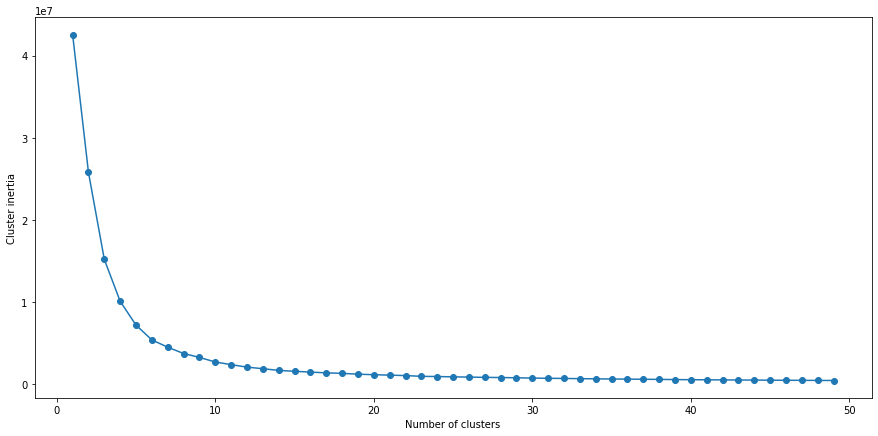

In [7]:
inertia = []
k_min=1
k_max=50
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(data_reduced)
    inertia.append(km.inertia_)
plt.rcParams['figure.figsize'] = [15,7]
plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

## Silhouette scores

For n_clusters = 7 The average silhouette_score is : 0.5413348
For n_clusters = 8 The average silhouette_score is : 0.5608779
For n_clusters = 9 The average silhouette_score is : 0.57165754
For n_clusters = 10 The average silhouette_score is : 0.58896816
For n_clusters = 11 The average silhouette_score is : 0.5580885
For n_clusters = 12 The average silhouette_score is : 0.5495838
For n_clusters = 13 The average silhouette_score is : 0.5251091


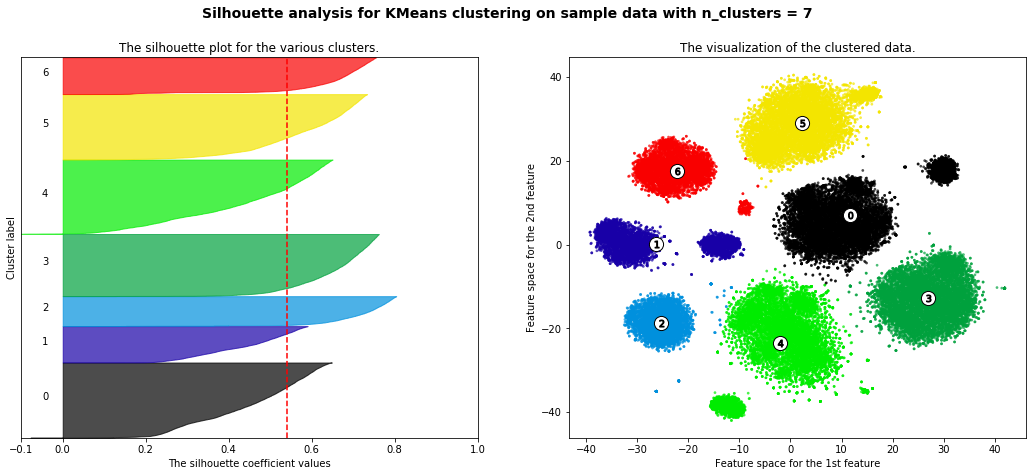

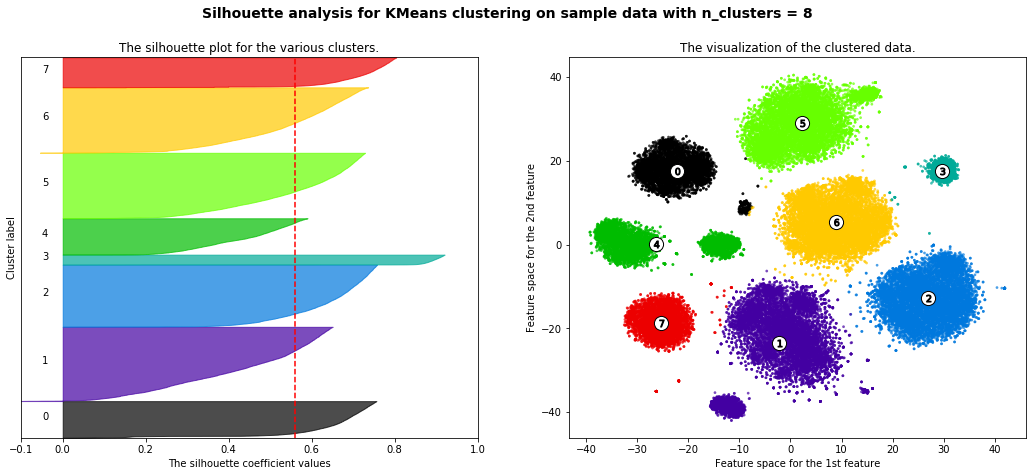

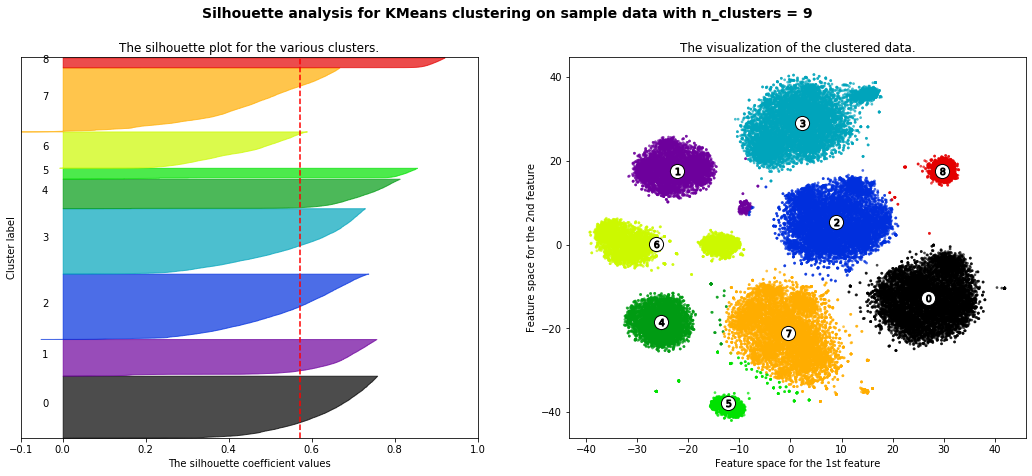

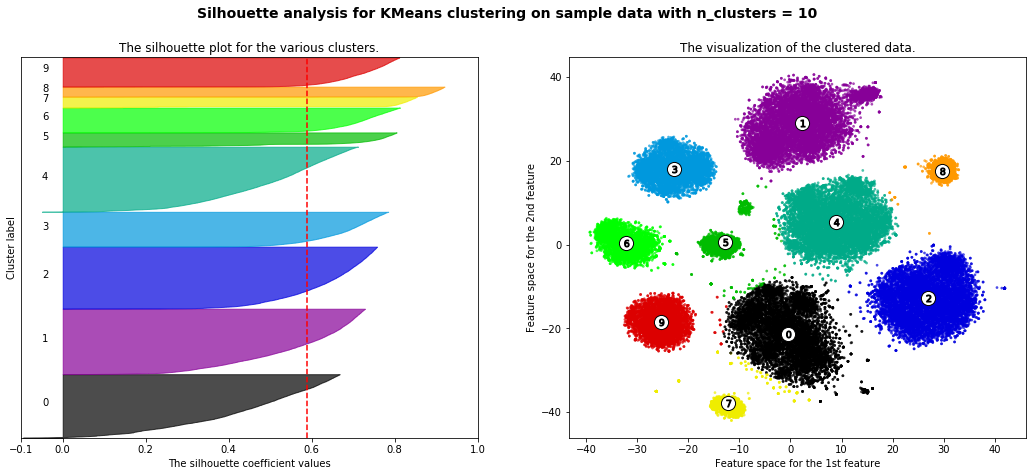

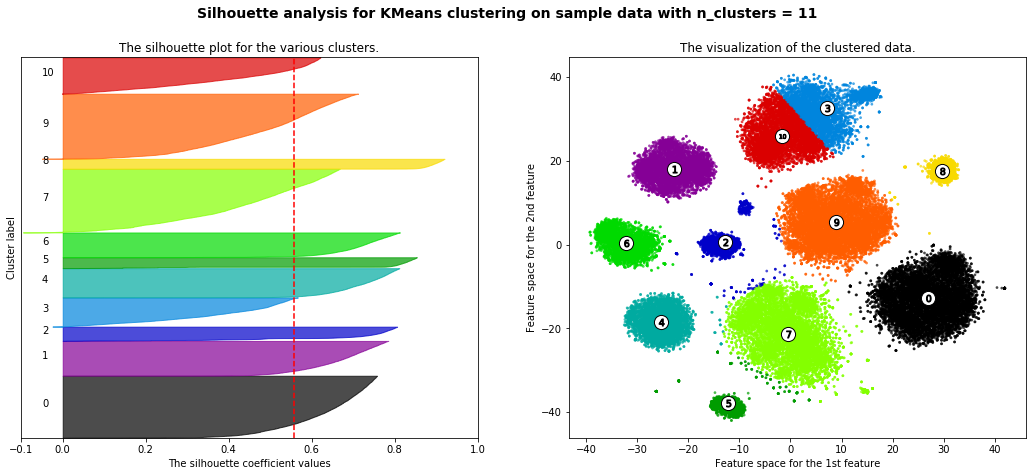

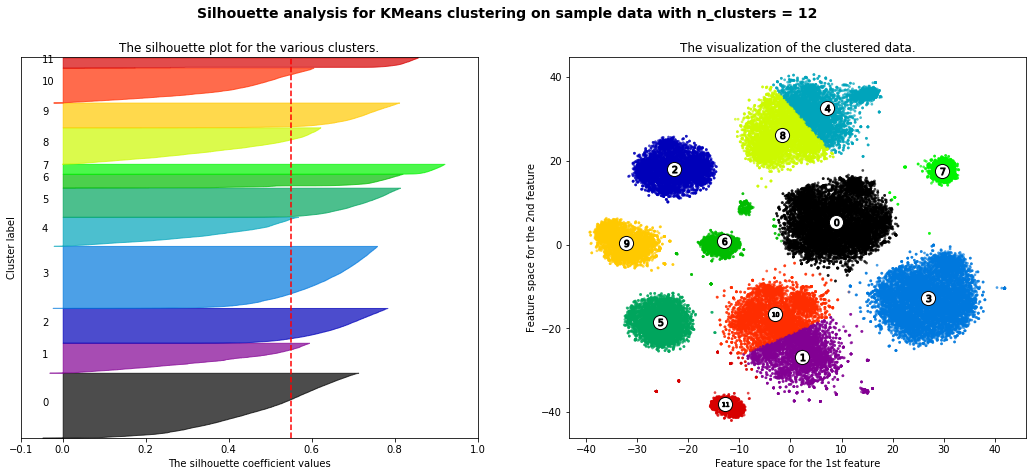

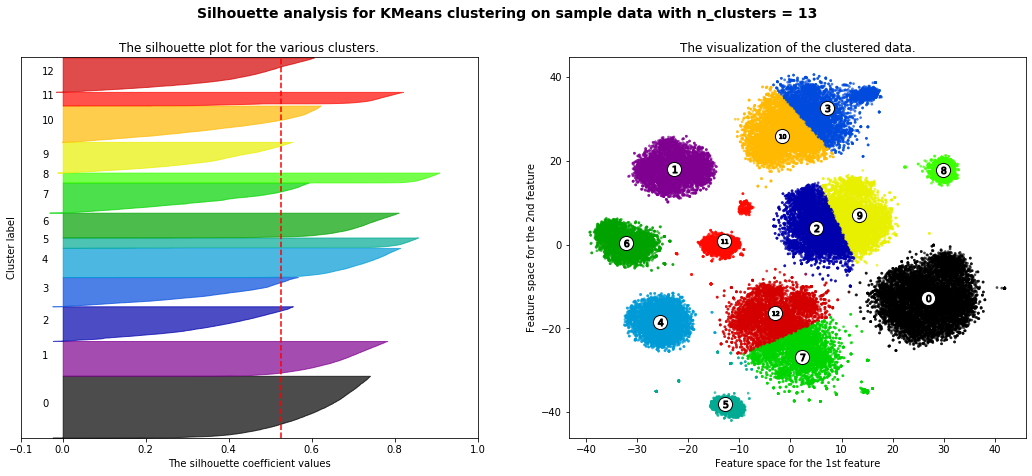

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range(7,14):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_reduced) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_reduced, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


## Analyzing with narrative

In [11]:
number_clusters = 10
km = KMeans(n_clusters=number_clusters,init='k-means++')
indexes = km.fit_predict(data_reduced)
centroids = km.cluster_centers_

df_index = pd.DataFrame(indexes)

indici = []
for i in range(0,len(indexes)):
    indici.append(i)
df1 = df_index.set_index(pd.Index(indici))
df2 = df.set_index(pd.Index(indici))
df_result = pd.concat([df1,df2], axis = 1)
print(df_result)

       0  Row No Date received                  Product  \
0      9    6874      09/09/16              Payday loan   
1      4   10840      08/07/15            Consumer Loan   
2      4   12248      08/07/16            Consumer Loan   
3      4   17162      05/26/16            Consumer Loan   
4      4   17642      11/05/15            Consumer Loan   
...   ..     ...           ...                      ...   
58030  0  222826      09/21/16  Bank account or service   
58031  0  142174      03/05/16  Bank account or service   
58032  0   55888      01/23/17  Bank account or service   
58033  0  293505      09/27/16  Bank account or service   
58034  0  327087      09/28/15  Bank account or service   

                      Sub-product                                     Issue  \
0                            None  Charged fees or interest I didn't expect   
1                    Vehicle loan       Problems when you are unable to pay   
2                    Vehicle loan                Manag

Cluster number: 0
i recently opened an account with bmo harris bank through the online platform the process itself took about an hour and they asked for multiple different documents and information which i have never been asked for previously once i completed the online portion i received an email stating that all parties and the account must call in and speak to a representative or the account would be closed upon calling into the bank i was asked the same questions that i just finished filling out online when my wife called and spoke with the representative they advised that the account was already opened and she did not need to speak with them which contradicts the email we received in order to open the account a deposit of was needed we opted to transfer money from an existing external account in order to verify the account the funds were coming from we were to receive small deposits from and then verify these deposits on the website once these deposits were received we were unable


i m being charged for atm withdrawals for which funds were not received each transaction was for for a total of usd chase back credited me for that amount on the date of the attempted withdrawal no receipt was given to me at atm on they took back the credit and on tomorrow they are taking the other back also as per their investigation this happen at they gave me the information on the owners of the atm s they told me that they ca n t do nothing until a count is done at the end of the week i reported it to security trying to get film footage of me to prove that i did not receive funds they refused because i was n t robbed come to find out the has happen before with a chase bank customer before so i felt that i would not be ripped off how wrong i was the claim number with chase bank is card ending account ending that casino has camera footage and it will show i did not receive funds 

suntrust bank not only charges you overdraft fees but after days they charge additional overdraft fee i

hello after opening up a citigold account for the promotional offer of aa miles i visited a local branch to verify that by using the promotional code given to me and meeting the account requirements i would be awarded the bonus miles i am well past the day requirement to issue my bonus and i have confirmation documentation via citi online chat that confirms i opened the bank account with the promotional offer in a valid fashion and that i have met the requirements therefore i would be rewarded the points by late since that period i have requested the miles three times being told that i would receive the miles within two business days 

i opened a checking account with citibank on in response to a promotion that i had received the promotion said i could earn by depositing and maintaining that balance for days and keeping the account open for days i decided to close the account on days after opening it i called citibank to close the account and confirmed that i had met the requirements t


this occurred about four years ago my father was staying at the on in california i had made one payment for him with my debit card and at the time i did so i had noticed that they were entering my credit card into a windows computer not just sliding it in a regular credit card machine so i was concerned that they were recording the card information i made it clear that this was a one time charge and that they did not have my permission so make further charges to the card and i asked them to not record the card number they agreed and assurred me that they would not make future charges to my card several weeks later i noticed that they had charged around to my account without asking my permission and without even informing me ahead of time that they were doing it i was very angry because there wasnt even enough money in my account to cover that charge and in putting that unauthorized charge through wells fargo had also caused a number of legitimate checks to bounce i believe they were c

on thursday i set up and was approved for a personal checking account with city national bank i was given an account number and routing number and was told by my account representative that i could begin immediately using the account and make appropriate direct deposit arrangements with companies or entities paying me to send money to my new account with city national bank on and i arranged with and did the appropriate paperwork with many companies and entities to being immediately sending money to my new account with cnb my account rep at cnb also ordered and sent via overnight my platinum check card and temporary pin number to me which i did receive on monday based on the account being opened on i closed an account with a existing financial institution on monday after informing over companies of my new account and new direct deposit instructions i was contacted by a very rude cnb representative stating my previously approved account was now being closed due to alleged negative inform

i opened a pnc bank account online they verified my identity by asking me specific security questions and i funded my account with an instant transfer through a debit card i then received my and account number and started to setup my direct deposit a few days later i got my atm card and tried to activate it and was told to contact the bank at the bank i was told my account was closed due to risk prevention and an incident i had in which was fully resolved my direct deposit was already setup i never received any communication from pnc that they are closing my account i still have n t received any communication about the closure but i have received marketing material and instructional mailings on how to use my new account my money both my funding and my payroll is now in the pnc account but it is on hold i have no access to it unless i take time off to go to the branch and get a check for my money if they were n t going to open an account for an incident years ago then they should includ

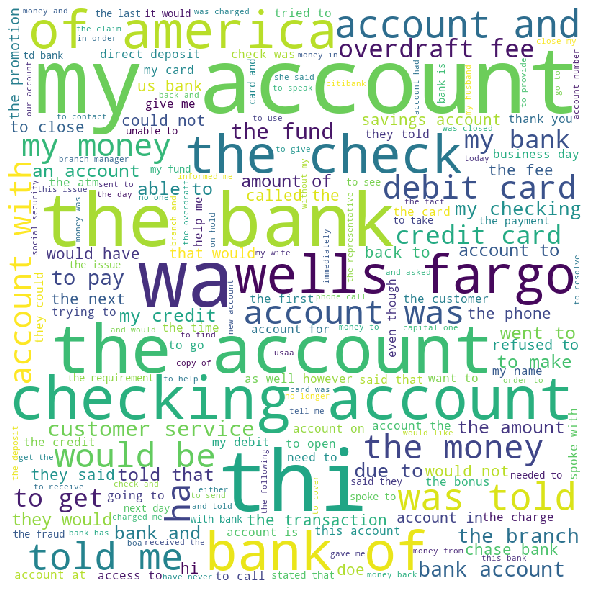

Cluster number: 1
where do i start equifax has destroyed my credit file i received an updated report and i am furious they removed several student loan accounts that are in good standing then they reinserted deleted collection accounts without giving me day notice required by federal fcra laws and added personal information to my account that is not mine they have broken and violated several of my consumer rights and federal laws that protect those rights they have purposely damaged my credit reputation with potential creditors and lenders what they have done is illegal i am not asking but demanding that they fix my credit file i am so livid right now i am ready to sue them for defamation violation of my consumer rights and undue stress with dealing with their incompetency i have contacted my consumer rights attorney did equifax not learn from the million settlement they had to payout because of their incompetency to insure that a consumer s credit file is reporting accurately and comp

they are reporting a lien on my credit i have no lien 

i m a victim of identity theft so there s a lot of increasing on my report i already contacted the creditors and they said they already send out letters to the creditors to remove the increase that does n t belong to me and for some reason and not removing them

equifax validated this account as accurate and correct even though the creditor responded that the account would be closed and deleted in response to my dispute equifax would not provide any method to get this item deleted from my record the told me on the phone that their investigation was complete and that it was validated and the information would remain i explained i had a signed letter from the creditor and they would not provide any way for me to submit this information to them in regard to this dispute 

i have requested my free credit report from all credit bureaus i have received the reports from and equifax has not submitted my credit report after requests made v


on looking over my monthly bank statement i noticed an unfamiliar charge on my bank statement contacted the bank to investigate found out the charge was fraud the fraud started through after solving the fraud situation with the bank i started seeking the damage of the fraud on i received a copy of my credit report going through the report i found a lot of negative issues not related to me i found bankruptcy information a social and health svcs dshs dcs account and credit inquires being reported as a negative towards my report i contacted experian credit bureau to dispute the false reporting of these issues my first attempt disputing through experian was mailed certified on receiving an updated credit report on experian removed some of the items i disputed but not all the items experian left on my credit report that should not be reported was some bankruptcy information credit inquires and the dshs scs account i also informed experian that if the bankruptcy information credit inquires 

Number of entries: 9712


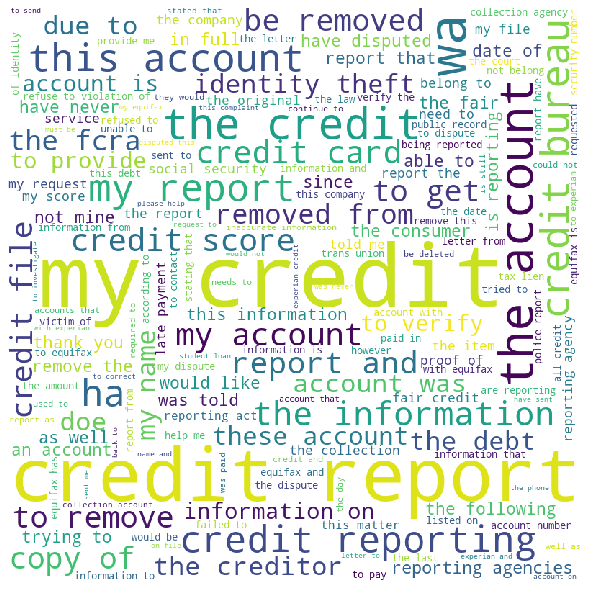

Cluster number: 2
fha is requiring me to be late due to a short sale via a hardship divorce proceedings were started and finalized last month ex wife i was mandated to pay child support to my ex wife for her and my children that share in part time custody i do live in the home over of the time due to the children reluctances to understand the divorce and are in the process of continuing to move out of the property i am currently living part time with my parents please release the deficiency of the loan balance as i am unable to pay the remaining balance owed and please apply me for any incentive programs the investor offers since this is technically my primary residence due to the divorce my household income has decreased over while my expenses have increased well over please see divorce decree for amount paid to my ex wife i do apologize for this and wish i was able to pay the balance i committed to but i do not see in the foreseeable future that i will be able to keep the home and cu

i obtained a loan thru navient previously known as the loan is no longer available but it was originally called a tuition answer loan i have all my documents but i borrowed back on not sure what happened between and but my loan increased to i was having financial difficulties and was not able to pay the loan on time and was behind and they finally worked out a payment with me right now as of today the documents state that i will have repaid by the time i pay this loan off which is ridicoulous that is way more than the amount i borrowed and i would like for this loan to be evaluated by the cfpb and see if there have been some unfair lending practices with this loan i am in over my head with these loans and i am unable to file them on my taxes because i was told that they are not student loans and they wanted me to call the school to ask if they can certify the loans so i can get federal tax credit i did n t call the school because i figured if they are not student loans then when i file

i have been consistently misled and kept in the dark about the process of my repayment and deferment i called on around and was told that i would be out of deferment and able to begin repaying my loans waving my rights for the grace period because of usurious interest rates of and other student lenders i accepted the period in which i was to wait to enter repayment lapsed and i was not notified and remained unable to begin repayment which i needed to refinance my loans i called to be told i was not going to be taken out of deferment but instead would need to send a letter to request to forego the grace period and deferment in order to begin repayment in the meantime i accrued interest at usurious rates the same story happened at discover i called on and was told i needed to send a letter to discover student lending services to remain out of deferment because the system fluctuates and takes people out of deferment no changes on my account occurred and i called back roughly days later ac

Number of entries: 4468


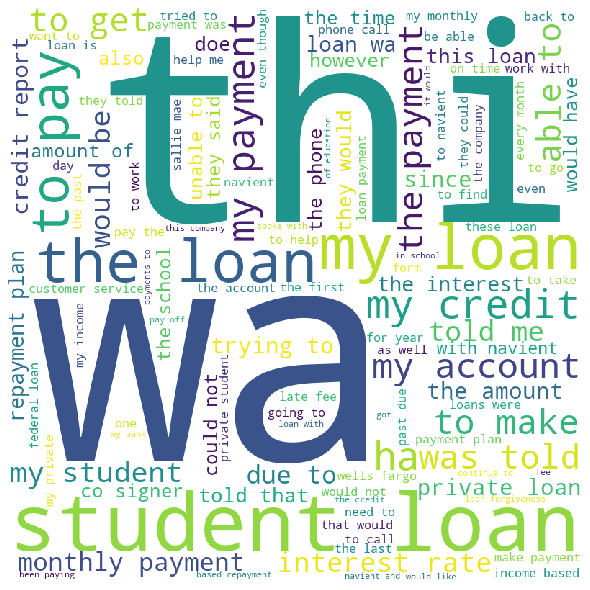

Cluster number: 3
i have repeated requested that gm financial correct their credit reporting on the auto loan that has been subject to a cancellation of debt i received the for tax year wherein i had to include it in my tax return and incurred tax consequences the continued reporting of a past due balance on my credit report is highly damaging to my ability to obtain favorable finance terms and is putting my family in a position where we are unable to secure housing due to this it s quite the troubling scenario i ca n t actually pay this bill to gm financial because it has been cancelled yet i am unable to correct my credit report and have it show that this debt is not past due as of this is a huge problem numerous correction attempts with the credit bureaus and gm financial have yielded no results i have done research on the topic and would like to advise both the cfpb and gm financial that this issue has been litigated extensively and that it has been decided numerous times by courts

citibank is calling on sunday morning at arizona time for a payment to a past due account per the federal guidelines it states calls can be made between on sundays this phone call was outside of these hours 

the following has been submitted to bank of america visa credit card disputes department duplicate charges and charge were made from in on the charge was correct but the charges were a mistake the paper was jammed and the charges were submitted three times so another charge was made at the restaurant bar for was added since person did not qualify for the discount on i had asked for the charges to be refunded but only was refunded in and again in i called about not receiving the other refunds but nothing was done i called again and was asked to write a letter because the agent could n t do anything about it since it has been more than a year the reply to the letter and a phone call to bank of america credit card billing disputes department was that they could not see the statements

my first statement from the company was sent directly to my husbands ex wife at her address instead of mine which was provided on the application for credit i was told by the company that this was a usps problem but upon receiving the statement from my husbands ex it was sent directly to her with no yellow sticker on the envelope the usps management not having anything on record 

i recently applied for a credit card through amazon com which cards are affiliated with chase bank i have only had the card months and have been making timely payments sometimes twice a month i recently paid my account on for i was sent a email stating they didnt receive payment this month and it is late and they attached a fee i made previous payment in for with no problem this time i was told i paid it too early i have to wait my bill is due on th of each month 

dear sir or madam on i was advised that of my citi credit cards were closed no representative from citi bank was able to explain why only out of s

purchased a piece of furniture on target com that stated it was in stock and able to be delivered with in a weeks to my door paid with my target red card credit card the wrong king size bed was delivered when the call to target com was placed the resolution was that the correct item has been expedited to deliver the correct item and remove the incorrect item from my home after waiting for weeks we had not heard from target s third party distributer so a call was placed we were told that no order has been received from target com to exchange these items after checking the website the correct bed had been placed on back order no call from target com about this issue the back order date was only weeks away so i said okay i ll wait weeks later i called and received the same news that target com never placed an order with them to exchange the wrong item looked on the website and the correct bed was placed on back order again but this time for more weeks going on weeks of having large boxes 

here is the correspondence sent on behalf of by attorney itadequately describes the situation to whom it may concern i have been retained by in regards to his elan visa classic card ending in elan visa please review credit history upon review you will find that opened up credit with elan sometime in has been faithfully making payments ever since and has a credit limit of approximately in of was offered a position through based out of new york offered compensation for training and benefits during negotiations with offered an opportunity to work on a part time project the project involved for would credit funds to elan visa and then upon receipt would purchase and ship the computers would then receive compensation for the transaction from had never done this sort of thing before so he phoned phone calls to elan visa were made on both and inquired as to the risk of this type of transaction if any enclosed you will find a copy of phone logs evidencing same phone is under the name of his ex

the american express website shows a balance figure called the current balance in a larger font than some other sub balances however this figure is actually the statement balance not the current outstanding balance so if you pay only the current balance you actually a leave a balance on the card and thus must pay a financing fee this is needlessly confusing and seems to be an attempt to bilk customers out of financing fees 

contacted about an unauthorized charge for on my card the agent claimed that i signed up for this service via phone in and incur a charge every time i use my card to rent a car i have no recollection of signing up and i have never received notification of this service from or this subsidiary the agent was most unhelpful and claimed that they would not refund the charge because i had already availed of their service he also cut me off when i asked to be transferred to a supervisor i called back and spoke to a lady named with much the same result very unhelpful and t

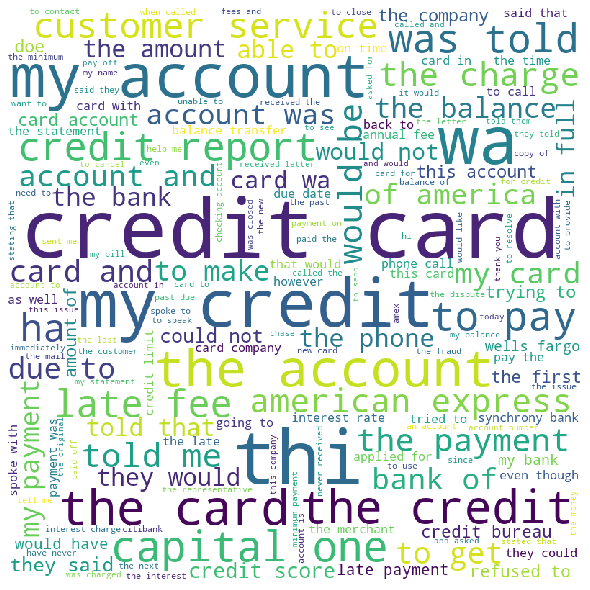

Cluster number: 4
drive time is harassing me by phone i have received phone calls in days from different numbers in nc az and ga i have blocked the number in ga but they continue to call me daily i have notified drive time that this number is blocked when i do n t answer the ga phone number they then call me from az or nc or both i have asked drive time to stop calling me daily i have asked drive time not to contact me more than once per week but they continue to call me daily yesterday i spoke to a drive time customer service agent at and they called me again at to discuss the same issue again i asked them to stop calling me and the agent claimed they did not call me more than once which is a lie i have asked drive time twice this week to stop calling me so often but they continue to call me daily i also have cosigned on a loan for my sister who lives with me they call her and when she does n t answer they then call me literally her phone rings then my phone rings they do n t leave he

i obtained a predatory loan triple digit apr through carma enterprises las vegas finance in my son of was accused of being involved in a crime the allegation were very serious and could not be taken lightly his defense is costing us of which we paid upfront and making payments of a month i contacted carmalv finance today to notify them of my reason for being past due and of my intentions of paying off the loan or getting back on track within the next few weeks pastdue balance biweekly payments since going past due for the first time as a customer on my payment weeks ago i have received a copious amount of collection calls on my cell and at work some days receiving up to two calls a day at work today i advised the manager that i can not receive calls at work especially with such aggressive tactics and disregard of business operations the manager advised me that he did n t care if the calls cost you your job you re not paying me so why should i care i again tried advising the manager of 

to whom it may concern i tried to reach a resolution on complaint with nissan to no avail the persons i needed to talk was always out of the office this was totally unacceptable i was willing to surrender the vehicle however i now want them to consider the loan paid off with nothing against my credit also a apology from texas nissan of and for his lies cheating and ways he shows know respect for vets nor their families all life matter regardless of race 

i have received hundreds of calls from this company despite being on the do not call registry i waited for the representative to appear on the line and i asked for the name of the company cardmember services and its main phone number this is i understand a capital one solicitation constant calls to say i owe money i have been in there payment protection plan for months even have the statements to prove where the payments have been made cant wait until i can get rid of them if they keep calling i will have no choice but to sue for hara

i was laid off this past summer and went and told this loan company this information the very first thing the manager did was to look and see what i could sell to pay the loan payment that was not overdue i continued to pay through the fall as i got severance pay when the severance pay exhausted and all i had was unemployment and could not pay the payment the manager said that i could come in and rewrite the loan then i would n t be due again until i was looking for work and had been since i was laid off with no luck i could not pay the payment so the loan company started calling me my dad my sister my daughter in law etc i had already told them i could not pay the payment as i had not landed a job yet when they called my sister she was in the hospital on oxygen and a bipap machine she told them she was in the hospital yet asked her to leave me a message i called the loan company and let them know that they were not ever to call my sister again my sisters doctor told her she may not li

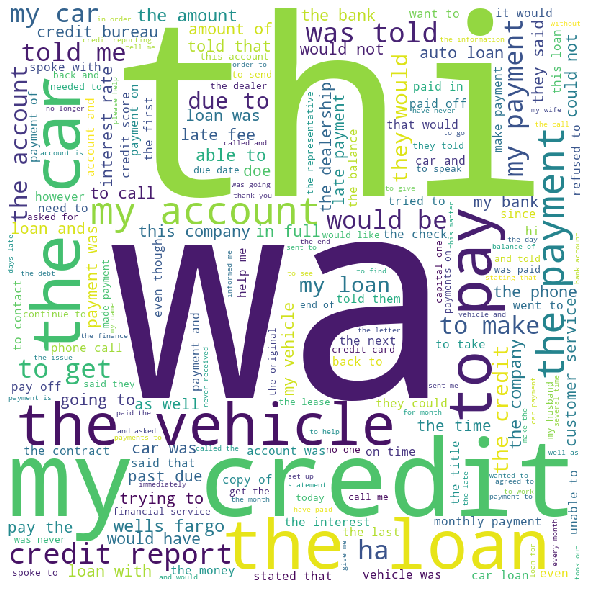

Cluster number: 5
we have received a letter dated stating that wells fargo did not receive the financial information required for a modification we were unable to review our account for additional payment assistance options wells fargo is aware that we are employed but is not able to assist us with a modification with employment status wells fargo also seems to have moved forward with charging my mortgage for foreclosure and forbearance at the same time all of wells fargo s efforts seem to be contradictory wells fargo s phone calls and different points of contact have created many missed opportunities to help transition from a forbearance program into a modification program that gets my mortgage out of water and assists me in sustaining a future mortgage we received a letter from wells fargo stating that they were responding to our request for assistance but we did not meet the requirements because we withdrew our request at no time did this occur we had previously sent letters in and 

i m filing a complaint because of the lack of help and correspondences from wells fargo with regards to the home of my aunt and last living relative the now deceased in an effort to modify and assume her loan as the assigned personal representative of the estate of i have sent the requested documents and they keep saying that they never received it and then request the same documents over and over again stating that they never received them i leave messages and they are not returned i requested modification assistance documentation and have not received it the desired outcome is to avoid foreclosure and postponement the sale date in order for me to submit foreclosure alternative paperwork to save her home from foreclosure 

i made my mortgage payment to cco mortgage in for the amount of this is the correct amount of the monthly payment the bank cashed the check for short i was assessed a late charge for the incorrect amount paid to the bank i called the bank and was told that this was 

when trees fell on my house and neighbors houses i began working with my insurance company a fantastic company to get the trees removed from the roofs the driveway and sidewalks replaced as well as replacing the shingles and some damaged wood trim the house is worth over and the mortgage balance is under i have already had the trees removed the cost of that was citibank required my insurance company to make the check payable to citibank and myself my insurance company said i should have no problem getting citibank to waive their interest in the check so that could direct deposit it into my account which i needed to fit into a cancellation that the driveway contractor had for i contacted citi on and made a request for them to notify that they were waiving their interest she said someone would call me from property damages no call so i called them they said that it was not their policy to do that even the supervisor was not helpful she submitted a request for a review to waive their inte


 has been working with servicer pennymac for over four years trying to accomplish a short sale or a deed in lieu first contacted her mortgage servicer when her hardship began to avoid foreclosure and find a resolution that benefited all parties involved upon review of the short sale in pennymac declined the short sale and encouraged to complete a deed in lieu of foreclosure instead upon completion of the dil review pennymac then advised to re list the property as a short sale and attempt the short sale this was incredibly misleading as the previous buyer walked when the short sale was declined now years have gone by without resolution on the debt and pennymac s unwillingness to work with her has caused the property to go into foreclosure once again in the property was listed for sale via a short sale and an offer was received on the property we ultimately had to dispute the value set forth by the va and we had an agreed upon adjusted value and offer in the amount of pennymac then issu

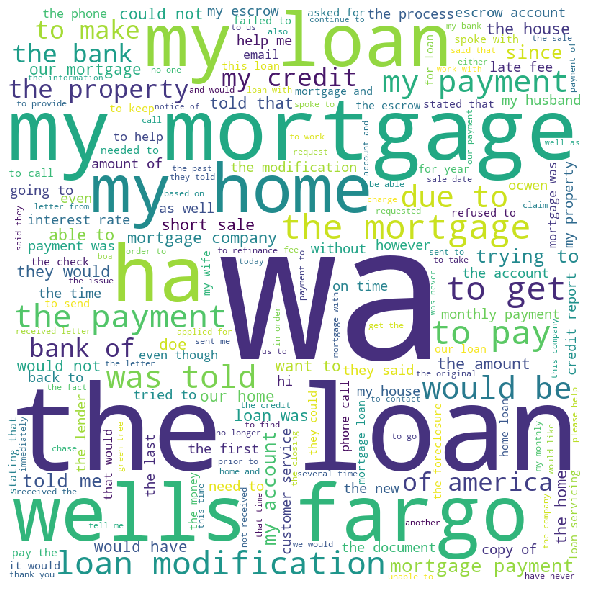

Cluster number: 6
just received a letter from service collecting for a local hospital debt is for a person with almost the same mane person that owes debt has different middle initial and living at a different address also some of the hospital visits are for a period when i was out of the country working for a company in just notified via mail individual is years younger than myself and has had trouble with the law in the past previous debtrestitution 

in and i was in contact with iq data international my main point of contact was we entered into agreement to pay in order to remove my name from a debt and all liability associated with it it was understood that upon receipt of payment they would report the settlement of the debt on my part to the major credit bureaus i rendered payment and have in my possession a receipt dated for indicating receipt of said payment and the agreement to follow as indicated above in an attempt to acquire shelter this month it has been discovered that the

i received county s original citation submitted by linebarger goggan blair sampson llp signed by attorney representing county toll road authority the citation states that i have to pay for the unpaid toll of that occurred on i have never received the original bill from that they claim they had mailed to me on according to county toll road authority it was only once first and final notice that the bill was mailed to me three years later without any reasonable option to pay the unpaid toll i was faced with the citation with the beyond unfair and unreasonable collection fee i am filing this grievance because the attorney representing county toll authority had not made any attempt to contact me and give me an opportunity to pay this toll i have tried several times to contact the law firm however i did not get any response 

back in i found a fraud account on my credit report and i called the company let them know this account was fraud i also sent over my police and ftc affdavit regarding 

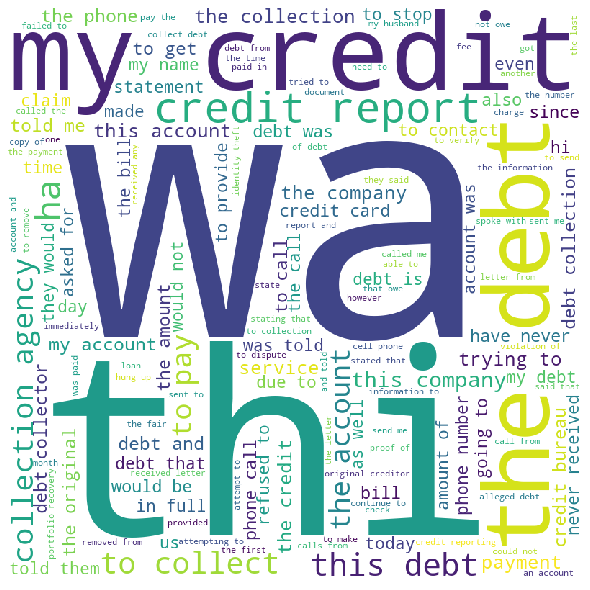

Cluster number: 7
on i loaded to my account ending in my account has since been frozen with no ability to use the card for debit transactions no bill pay functions no ability whatsoever to transfer money off the card 

 i notice a unauthorized foreign transaction was pending on my paypal prepaid card i immediately alerted paypal prepaid and they did nothing about it i researched the charge and learned that the charge has been reported by a lot of people as suspicious and fraud then paypal prepaid took it upon themselves to cancel that card without my consent without giving me a chance to pull the rest of the money i had in the account out and they left me with no way at all to access the funds they did this to me at the worst possible time which was they left me broke and and i did n t get to celebrate or enjoy the holidays at all they cause me so much hardship and had me waste so much time and energy everyday for the next weeks calling them trying to access my funds they would have me

you still have not read the court order that you must delete the bankruptcy in the state of va are you reading i address the inquires and told you again the companies do not respond when they do respond they tell me the same things you do you point the finger at them they point it at you nothing gets deleted i need this solved this is not solved i get the same all the time this is why you guys get suited do it have to do the same i give you everything you ask for and i still verified if you have a problem contact the companies that accessed your report i have done that and they go who are you again send us more info send us your picture id done that send us your diver id done that we can find you contact the the credit report agency they placed the inquire on your report not our problem i ask them remove it we ca n t find any record of you contact the credit report agency i do that and you go verified i need this deleted this is why need people to see this so many poepl have the same p

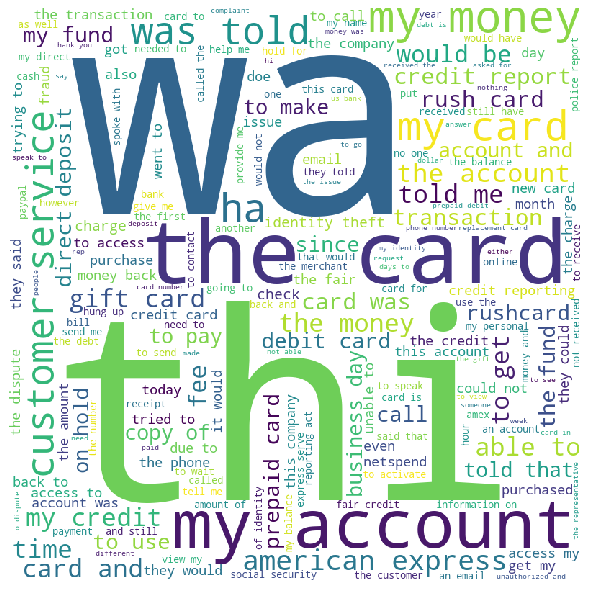

Cluster number: 8
i paid usd for computerinternet related services he was to log into my game account and tweak my game to give me better options and play he took the money but never delivered the services the payment was made with my card via paypal i attempted to dispute the charge with both paypal and but neither would help because they do not recognize the transaction as being for goods and services is a freelance gamer who accepts payment via paypal sent to the recipient of this payment is non u s verified email payment amount in currency funded usdyour fees usdyour total charge usdpayment amount usd fees usd receives usddate time pdtstatus completedfunds will be available to your recipient on or before note the recipient can send or spend the full amount on this date if the recipient wishes to withdraw money limits may apply subject you have sent usd to with paypalfunding type instant transferfunding source usd checking confirmed back up funding source mastercard debit card 

on 

Number of entries: 1525


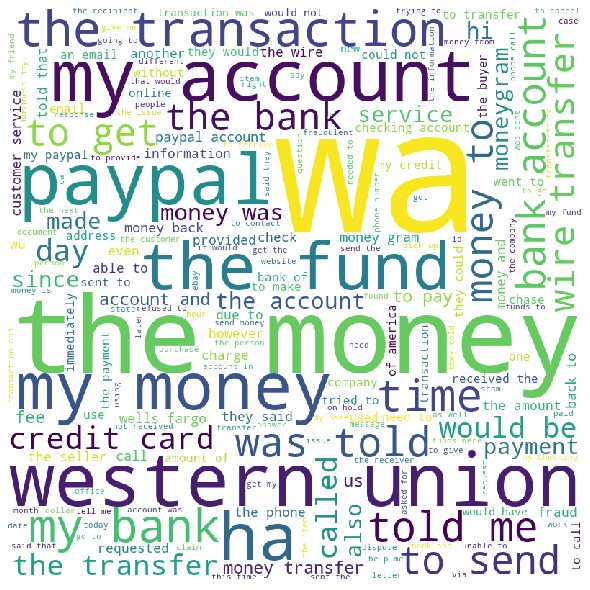

Cluster number: 9
had an agreement with checkcare systems in ga f or a month f ee they would guarantee payment of any nsf check writte n to my business as long as i had the proper information recorded on the check and it was or less we also had an agreement if they were able to collect on checks that did n t meet those criteria they would pay me for them if they were able to collect them they were supposed to issue me monthly checks along with reports showing which checks they received from my business my bank automatically sent all my returned checks to checkcare systems for collection they stopped sending me the money they collected on my behalf so i told them to stop drafting my account the month service fee until they paid me what they owed me in of i spoke to who said he was a manager th ere and told him to deduct the monthly service fees from what i was owed and send me the money they owed me he said he would do that since out conversation in of i receiv ed p ayment from checkcar

illegal interest rates charged in louisiana by call call also these companies may not be licensed consumer lenders in louisiana i have paid back over times the amount i borrowed this situation has caused a strain on my marriage my interest rate was at or above louisiana interest rate cap on personal consumer or revolving loans is i am using this complaint as a cease and desist letter i borrowed and paid back as on does that seem fair i know you are helping other states so please help louisiana residents too 

i borrowed on from a company called north cash and i knew that it would be an expensive loan if i did n t pay it off early the representative even stated that if i were to pay the loan off early i would save significantly on finance charges the finance charges that i am being charged are every two weeks i called in early to get my pay off balance and was told at that point that the payoff amount would be over ca n t remember the exact amount i was confused because at this point i 

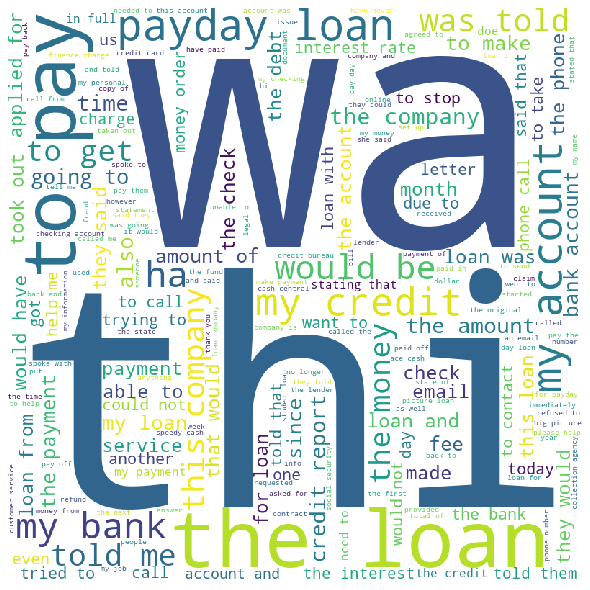

In [12]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import random

#if it's your first time running with these stopwords, run the following line aswell:
#nltk.download('stopwords')

stopwords = set(stopwords.words('english'))
stopwords.add('xx')

for i in range(0,number_clusters):
    all_words = ''
    print('Cluster number: '+str(i))
    amount = 0
    for index, row in df_result.iterrows():
        if row[0] == i:
            all_words += ' ' + row['Consumer complaint narrative']
            rand = random.randint(1,200)
            amount += 1
            if(rand == 1):
                print(row['Consumer complaint narrative'] + '\n')
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words) 
    print('Number of entries: ' + str(amount))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
